In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

In [2]:
os.chdir("../")

In [3]:
%pwd

'c:\\Personal AI Projects\\FORAGE JOB SIMULATIONS\\British Airline Data Science Virtual Internship\\customer-reviews-analysis'

In [4]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class DataAnalysisConfig:
    root_dir: Path
    source_data_path: str


In [5]:
from src.reviewAnalyzer.constants import *
from src.reviewAnalyzer.utils.common import read_yaml, create_directories

In [6]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH):
        self.config = read_yaml(config_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_data_analysis_config(self) -> DataAnalysisConfig:
        config = self.config.data_analysis
        create_directories([config.root_dir])

        data_analysis_config = DataAnalysisConfig(
            root_dir=config.root_dir,
            source_data_path=config.source_data_path
        )

        return data_analysis_config


### data_analysis.py

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from src.reviewAnalyzer import logger
from src.reviewAnalyzer.utils.common import *
from src.reviewAnalyzer.entity.config_entity import DataAnalysisConfig
from pathlib import Path

In [8]:
class DataAnalysis:
    def __init__(self, config: DataAnalysisConfig):
        self.config = config
        self.file = self.config.source_data_path
        self.sentiment_analyzer = SentimentIntensityAnalyzer()

        
    # function to calculate vader sentiment
    def sentiment_analysis(self, text):
        vs = self.sentiment_analyzer.polarity_scores(text)
        return vs['compound']
    

    # function to analyse and create a new feature with sentiments
    def vader_analysis(self, compound):
        if compound >= 0.5:
            return 'Positive'
        elif compound < 0 :
            return 'Negative'
        else:
            return 'Neutral'



In [9]:
class DataAnalysisPipeline:
    def __init__(self):
        pass

    def main(self):  
        config = ConfigurationManager()
        data_transformation_config = config.get_data_analysis_config()
        
        data_analysis = DataAnalysis(config=data_transformation_config)
        data = load_data(data_transformation_config.source_data_path)
        data = data.reset_index(drop=True)

        # Sentiment Analysis using VADER
        data['sentiment'] = data['corpus'].apply(data_analysis.sentiment_analysis)
        data['analysis'] = data['sentiment'].apply(data_analysis.vader_analysis)

        title = 'Review Sentiment Chart'
        plot_piechart(
            data['analysis'].value_counts(),
            Path(data_transformation_config.root_dir+'/'+title+'.png'),
            title
            )
        logger.info(f"Sentiment analysis calculated")
        logger.info(f"{title} saved at {data_transformation_config.root_dir+'/'+title+'.png'}.")

        title = 'Verified Reviewer Trip Chart'
        plot_piechart(
            data['verified'].value_counts(),
            Path(data_transformation_config.root_dir+'/'+title+'.png'),
            title
            )
        logger.info(f"{title} saved at {data_transformation_config.root_dir+'/'+title+'.png'}.")

        show_wordcloud(data.corpus, Path(data_transformation_config.root_dir+'/wordcloud'+'.png'))
        logger.info(f"Wordcloud image saved at {data_transformation_config.root_dir+'/wordcloud'+'.png'}.")



In [10]:
from src.reviewAnalyzer.exceptions import CustomException

[2024-07-09 20:39:42,594: INFO: 1933612284: *******************]
[2024-07-09 20:39:42,596: INFO: 1933612284: >>>>>> Data Analysis Stage started <<<<<<]
[2024-07-09 20:39:42,602: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-07-09 20:39:42,608: INFO: common: created directory at: artifacts]
[2024-07-09 20:39:42,613: INFO: common: created directory at: artifacts/data_analysis]
Loading source data file...
[2024-07-09 20:39:43,038: INFO: common: Data file (artifacts/data_transformation/data-v1.0.csv) loaded]
[2024-07-09 20:39:46,452: INFO: 3291584610: Sentiment analysis calculated]
[2024-07-09 20:39:46,454: INFO: 3291584610: Review Sentiment Chart saved at artifacts/data_analysis/Review Sentiment Chart.png.]
[2024-07-09 20:39:46,750: INFO: 3291584610: Verified Reviewer Trip Chart saved at artifacts/data_analysis/Verified Reviewer Trip Chart.png.]
[2024-07-09 20:39:48,016: INFO: 3291584610: Wordcloud image saved at artifacts/data_analysis/wordcloud.png.]
[2024-07-09

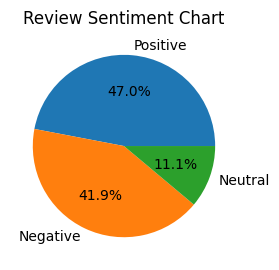

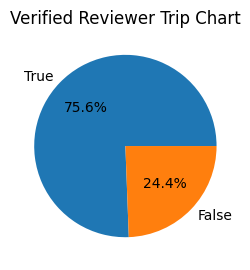

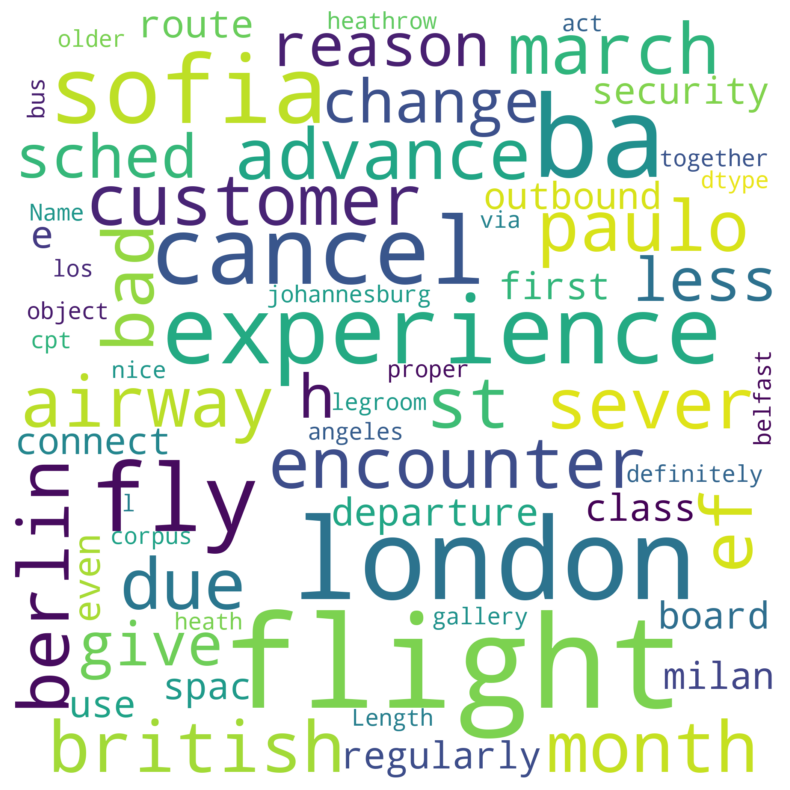

In [11]:
STAGE_NAME = "Data Analysis Stage"

try: 
   logger.info(f"*******************")
   logger.info(f">>>>>> {STAGE_NAME} started <<<<<<")
   data_analysis = DataAnalysisPipeline()
   data_analysis.main()
   logger.info(f">>>>>> {STAGE_NAME} completed <<<<<<]\n\n[x==========x")
except Exception as e:
    logger.exception(e)
    raise CustomException(e, sys)